
# Generador de Textos con PyTorch

Vamos a utilizar el framework [PyTorch](https://pytorch.org/) para implementar la RNR.

<img src="figuras/pytorch-logo.svg" width="50%">

Es un paquete de Python diseñado para realizar cálculos numéricos haciendo uso de la programación de tensores. Además permite su ejecución en GPU para acelerar los cálculos.

Normalmente PyTorch es usado tanto para sustituir numpy y procesar los cálculos en GPU como para la investigación y desarrollo en el campo del aprendizaje automático, centrado principalmente en el desarrollo de redes neuronales.

PyTorch es una librería muy reciente y pese a ello dispone de una gran cantidad de manuales y [tutoriales](http://pytorch.org/tutorials/) donde encontrar ejemplos. Además de una comunidad que crece a pasos agigantados.

PyTorch dispone una interfaz muy sencilla para la creación de redes neuronales pese a trabajar de forma directa con tensores sin la necesidad de una librería a un nivel superior como pueda ser Keras para Theano o Tensorflow.

Al contrario que otros paquetes como Tensorflow, PyTorch trabaja con grafos dinámicos en vez de estáticos. Esto significa que en tiempo de ejecución se pueden ir modificando las funciones y el cálculo del gradiente variará con ellas. En cambio en Tensorflow debemos definir primero el grafo de computación y después utilizar la session para calcular los resultados de los tensores, esto dificulta la depuración de código y hace más tediosa su implementación.

PyTorch dispone de soporte para su ejecución en tarjetas gráficas (GPU), utiliza internamente CUDA, una API que conecta la CPU con la GPU que ha sido desarrollado por [NVIDIA](http://www.nvidia.es/page/home.html).

Para instalar PyTorch ejecutar el siguiente comando:

`conda install pytorch torchvision -c pytorch`



In [ ]:
Las Redes Neuronales Recurrentes se pueden utilizar para la generación de texto. En este ejemplo utilizaremos una RNR del tipo GRU para generar texto usando como conjunto de entrenamiento el Don Quijote de Miguel de Cervantes Saavedra.

![Miguel de Cervantes Saavedra](figuras/cervantes.jpg)

## Preparación de datos 

Si no tienes instalada la libreria unidecode ingresa el siguiente comando en Linux
```
conda install -c anaconda unidecode
```

In [3]:
import unidecode
import string
import random
import re

#para la clase RNN
import torch
import torch.nn as nn
from torch.autograd import Variable

#Para medir tiempos de ejecucion y calculos 
import time, math

todos_caracteres = string.printable
n_caracteres = len(todos_caracteres)

archivo = unidecode.unidecode(open('datos/don_quijote.txt',encoding="UTF-8").read())
tam_archivo = len(archivo)
print('Tamaño del archivo en caracteres: ', tam_archivo)

Tamaño del archivo en caracteres:  2071608


Ahora fragmentaremos el texto

In [4]:
longitud_fragmento = 1000

def fragmento_aleatorio():
    i_ini = random.randint(0, tam_archivo - longitud_fragmento)
    i_final = i_ini + longitud_fragmento + 1
    return archivo[i_ini:i_final]

print(fragmento_aleatorio())

d puede ver?

Mirole entonces el oidor mas atentamente y conociole; y, abrazandole, dijo:

-?Que ninerias son estas, senor don Luis, o que causas tan poderosas, que
os hayan movido a venir desta manera, y en este traje, que dice tan mal con
la calidad vuestra?

Al mozo se le vinieron las lagrimas a los ojos, y no pudo responder
palabra. El oidor dijo a los cuatro que se sosegasen, que todo se haria
bien; y, tomando por la mano a don Luis, le aparto a una parte y le
pregunto que venida habia sido aquella.

Y, en tanto que le hacia esta y otras preguntas, oyeron grandes voces a la
puerta de la venta, y era la causa dellas que dos huespedes que aquella
noche habian alojado en ella, viendo a toda la gente ocupada en saber lo
que los cuatro buscaban, habian intentado a irse sin pagar lo que debian;
mas el ventero, que atendia mas a su negocio que a los ajenos, les asio al
salir de la puerta y pidio su paga, y les afeo su mala intencion con tales
palabras, que les movio a que le respondiesen

## Construyendo el modelo

In [5]:
class RNN(nn.Module):
    def __init__(self, tam_entrada, tam_oculto, tam_salida, num_capas=1):
        super(RNN, self).__init__()
        self.tam_entrada = tam_entrada
        self.tam_oculto = tam_oculto
        self.tam_salida = tam_salida
        self.num_capas = num_capas
        
        self.encoder = nn.Embedding(tam_entrada, tam_oculto)
        self.gru = nn.GRU(tam_oculto, tam_oculto, num_capas)
        self.decoder = nn.Linear(tam_oculto, tam_salida)
    
    def forward(self, entrada, oculta):
        entrada = self.encoder(entrada.view(1, -1))
        salida, oculta = self.gru(entrada.view(1, 1, -1), oculta)
        salida = self.decoder(salida.view(1, -1))
        return salida, oculta

    def init_hidden(self):
        return Variable(torch.zeros(self.num_capas, 1, self.tam_oculto))

## Entradas y objetivos

In [6]:
# Convierta la cadena en una lista larga
def caracter_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = todos_caracteres.index(string[c])
    return Variable(tensor)

print(caracter_tensor('abcDEF'))

Variable containing:
 10
 11
 12
 39
 40
 41
[torch.LongTensor of size 6]



In [7]:
def conjunto_entrenamiento_aleatorio():    
    pedazo = fragmento_aleatorio()
    entrada = caracter_tensor(pedazo[:-1])
    objetivo = caracter_tensor(pedazo[1:])
    return entrada, objetivo

## Evaluando

Para evaluar la red la alimentaremos con un carácter a la vez, usaremos los resultados de la red como una distribución de probabilidad para el siguiente carácter y repetiremos este proceso.

In [8]:
def evaluar(prime_str='A', predict_len=100, temperature=0.8):
    oculta = decoder.init_hidden()
    entrada_principal = caracter_tensor(prime_str)
    prediccion = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, oculta = decoder(entrada_principal[p], oculta)
    entrada = entrada_principal[-1]
    
    for p in range(predict_len):
        salida, oculta = decoder(entrada, oculta)
        
        # Muestra de la red como una distribución multinomial
        distribucion_salida = salida.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(distribucion_salida, 1)[0]
        
        # Add predicted character to string and use as next input
        caracter_predicho = todos_caracteres[top_i]
        prediccion += caracter_predicho
        entrada = caracter_tensor(caracter_predicho)

    return prediccion

## Entrenamiento

In [9]:
def tiempo(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [10]:
def entrenamiento(entrada, objetivo):
    oculta = decoder.init_hidden()
    decoder.zero_grad()
    perdida = 0

    for c in range(longitud_fragmento):
        salida, oculta = decoder(entrada[c], oculta)
        perdida += criterion(salida, objetivo[c])

    perdida.backward()
    decoder_optimizer.step()

    return perdida.data[0] / longitud_fragmento

Definimos los parámetros de entrenamiento, instanciamos el modelo y comenzamos a entrenar:

In [11]:
max_epoch = 4000 #numero de epoch para el entrenamiento
impresion = 100
graficar = 10
tam_oculto = 100
num_capas = 2
epsilon = 0.005

decoder = RNN(n_caracteres, tam_oculto, n_caracteres, num_capas)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=epsilon)
criterion = nn.CrossEntropyLoss()

comienzo = time.time()
historial_perdidas = []
prmedio_perdida = 0

for epoch in range(1, max_epoch + 1):
    perdida = entrenamiento(*conjunto_entrenamiento_aleatorio())       
    prmedio_perdida += perdida

    if epoch % impresion == 0:
        print('[%s (%d %d%%) %.4f]' % (tiempo(comienzo), epoch, epoch / max_epoch * 100, perdida))
        print(evaluar('J', 100), '\n')

    if epoch % graficar == 0:
        historial_perdidas.append(prmedio_perdida / graficar)
        prmedio_perdida = 0

 49s (100 2%) 2.1408]
Jue cuimebanra hi
ques ula vano y tua arel cober que rella, que yres rado hiera como ananio la y, esp 

 39s (200 5%) 1.9594]
Juescos a a quulo de una bues las de por lo podircia quien mas de estes de viante lerres reseyos sin  

 30s (300 7%) 1.9847]
Jos dieso de senol rerbres conores, que dunas, y duiecha, pero almeso, decio a Han despero su me ya g 

 23s (400 10%) 1.7691]
Jo su suciando se dole contos la desencella atido y, a calibando de mera habia cielmara de el con la  

 16s (500 12%) 1.7362]
Ja-; por lo esposo, y yeste y tos de pusto y mo resparo que a ampo
con adabes de no la se haber la lo 

 11s (600 15%) 1.7628]
Juestros acomenia, ni feguacivinio la hate pritajos si de la mas pedia mano, y la mandante grales de  

 5s (700 17%) 1.6553]
Juesa, por en el vida de hoimbre destas tojos al mibien deseres y las leco que descubrido de lo el bu 

 0s (800 20%) 1.6417]
JAso el higaba, que, por
es. Dillo canto de haber por de los quita senor a con
presunos, y,
y

## Graficación de los errores

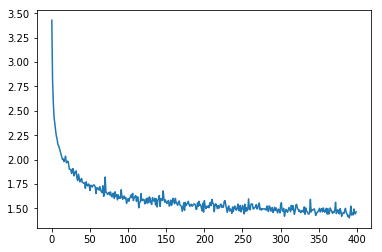

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(historial_perdidas)

## Resultados con diferentes temperaturas 

En la función de evaluación anterior, cada vez que se realiza una predicción, las salidas se dividen por el argumento "temperatura" pasado. Usar un número más alto hace que todas las acciones sean más equitativas y, por lo tanto, nos brinda salidas "más aleatorias".

Usar un valor más bajo (menos de 1) hace que las probabilidades altas contribuyan más. A medida que aumentamos la temperatura hacia cero, estamos eligiendo solo las salidas más probables.

In [13]:
print(evaluar('Caballero', 1000, temperature=0.8))

Caballero
es padre, acierno.

Y, debada en
regocinia, y para de adelantes, que te los dico y
dijo don Fernando no me sera aquel comparon de aquella, peso de la de unas el cual de virtud, que estaba salido de don Quijote, pues, bico, y que no te desosas primerle se
purto. Su el letrado que de los primerosos que todos apartastros de
su remedia a los mas fuerza de la suerte de lo que te corrales mas desta parte muchas otras respondio:

         


Capalaba, que aquel primera, sin grrado a su largo, sin
espada: que se es de orrea que quiso se han de las presentes que caballero y bese
cuales dar a
le tiempo aventura.











Capitulo
es esto se saber de real y ser cabrero dorperon un tremer en don Quijote Coro, y una puerta trasfu era Loto y estos razon con esta de lo que no haciendera y creer un das como decir todos los
desdetas espacuia, porque yo por aqui pensamiento que tomo te pasadas de una que
desta bien esta acerrara para
principito a su sabian a la cuerdo, porque nunca la mandab

In [14]:
print(evaluar('Togoso', 1000, temperature=0.2))

Togoso de la casa de la de la mano de la de los desde alguna de los desmas de los despues de la mano de la casa de su arralado, que te despues de la caballero de la mano de la de aquel de la caballero de la de la caballero y de la mano de la caballero, que es de la verdad de los despues de aquella de su para de los desenvaas de la mano de la de la caballero de la caballero de la caballero de los despues de la mano de la caballero de su para de la de la de la de su para de la de la caballero de la de su caballero de los destas de sus despecho de la de la manos de su senora de la de la caballero de la manos de la de la caballero de la de la parece de los destas destas destas de sus pasados de la mano de la caballero de la casa de su amor de la de la desencantado de la caballero de los destas de las caballeros de los despues de los destas de su senora de la pierdo de su amor de la caballero de los dos de la caballero de su arromente de la caballero de los destas destas destas manos de la 

In [15]:
print(evaluar('Sancho', 1000, temperature=.5))

Sancho sino de nuestra de los brazos que el traza de las dias que la discresa y a tal y a la habia se desta verdad de la bajas servir de los destas deste pierdole de la companero, y a sus arrazon tenia de aquel respondio de los andantes, que de arrica de para de no me tengo de la dia de dos desasia y decir y saber con sus ardenados, y asi tanto, que ahora de su respondio del caminos estas caminar sin mas de descontiga a esta ventura, que se estandole de aquella principales por don Fernandole de los desenvase de aquello de priesa de panero de un mananas de los cosas que del cual, que a don Quijote, cuando le deste despues puntas, porque a la cuales se esas de voluntad de aquella saber en manera
consentado que las dardas y la sabir para de la de manera se aqui esta orden de aquel senora se determir de padre y trabajas que le dije que se puede la manos de la caballero, sin dandole de la venta de la que alguna le dieron de todas caballeros de la alguna sana trazo y le dijo que es de los re